# Deep Learning Evaluation - DeBERTa Model

This notebook evaluates Gaby's pre-trained DeBERTa model on the Rakuten product classification task.

## Objectives

1. Load and evaluate a pre-trained DeBERTa model (no retraining)
2. Apply Gaby's preprocessing pipeline with special tokens
3. **Two-Stage Evaluation**:
   - **Stage 1**: Development evaluation on X_dev validation split
   - **Stage 2**: Final evaluation on X_holdout (for fair comparison with NB01-03)

## Model Details

- **Model**: DeBERTa (from `models/text/deberta_v1_20251218/`)
- **Preprocessing**: `text_preprocess` from `gaby_preprocessing.py`
- **Input Format**: `[TITRE] designation [DESC] description`
- **Output**: 27 product categories (indices 0-26)

## Data Split Strategy (Following NB01-03 Convention)

```
Total Data (84,916)
    ↓
    ├─ X_dev (72,178, 85%)     ← Stage 1: Development & validation
    │   ├─ train (61,351, 85%)
    │   └─ val (10,827, 15%)    [random_state=42]
    │
    └─ X_holdout (12,738, 15%)  ← Stage 2: Final evaluation
```

---

## 1. Setup & Imports

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Data & ML libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report, 
    confusion_matrix
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch & Transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification
)
from tqdm.auto import tqdm

# Add project paths
sys.path.insert(0, '../src')
sys.path.insert(0, '../scripts')

# Import Gaby's preprocessing
from rakuten_text.gaby_preprocessing import text_preprocess, LABELS_DICT
from load_data import split_data

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ All imports successful")

✓ All imports successful


## 2. Configuration (Following NB01-03 Convention)

In [2]:
# Configuration constants (matching NB01-03)
VAL_SIZE = 0.15
RANDOM_STATE = 42

# Model configuration
MAX_LENGTH = 128  # Max sequence length (can try 256 if GPU memory allows)
BATCH_SIZE = 16   # Conservative batch size to avoid OOM errors
MODEL_PATH = "../models/text/deberta_v1_20251218/"

# Set device (CUDA if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Configuration:")
print(f"  VAL_SIZE: {VAL_SIZE}")
print(f"  RANDOM_STATE: {RANDOM_STATE}")
print(f"  MAX_LENGTH: {MAX_LENGTH}")
print(f"  BATCH_SIZE: {BATCH_SIZE}")
print(f"  DEVICE: {device}")

if device.type == 'cuda':
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Configuration:
  VAL_SIZE: 0.15
  RANDOM_STATE: 42
  MAX_LENGTH: 128
  BATCH_SIZE: 16
  DEVICE: cuda
  GPU: NVIDIA GeForce RTX 4070 Laptop GPU
  GPU Memory: 8.59 GB


## 3. Data Loading

Load data using the same `split_data()` function to ensure consistency across all notebooks.

In [3]:
# Load data with consistent split (85% dev, 15% holdout)
print("Loading data...")
X_dev, X_holdout, y_dev, y_holdout = split_data()

# Create dataframes
df_dev = X_dev.copy()
df_dev['prdtypecode'] = y_dev

df_holdout = X_holdout.copy()
df_holdout['prdtypecode'] = y_holdout

print(f"✓ Data loaded: {len(df_dev) + len(df_holdout):,} total samples")
print(f"  Development set: {len(df_dev):,} samples (85%)")
print(f"  Hold-out set:    {len(df_holdout):,} samples (15%)")
print(f"\nColumns: {list(df_dev.columns)}")

Loading data...
✓ Data loaded: 84,916 total samples
  Development set: 72,178 samples (85%)
  Hold-out set:    12,738 samples (15%)

Columns: ['designation', 'description', 'productid', 'imageid', 'prdtypecode']


## 4. Text Preprocessing (Gaby's Pipeline)

Apply Gaby's preprocessing with special tokens to both dev and holdout sets.

In [4]:
print("Preprocessing development set...")

# Preprocess designation and description
df_dev['designation_clean'] = df_dev['designation'].fillna("").apply(text_preprocess)
df_dev['description_clean'] = df_dev['description'].fillna("").apply(text_preprocess)

# Construct input text with Gaby's special tokens
# CRITICAL: Use the exact format Gaby used during training
df_dev['text'] = "[TITRE] " + df_dev['designation_clean'] + " [DESC] " + df_dev['description_clean']

print(f"✓ Development set preprocessed")
print(f"\nExample text:")
print(f"{df_dev['text'].iloc[0][:200]}...")

Preprocessing development set...
✓ Development set preprocessed

Example text:
[TITRE] Happy Day Indépendance Coussin Coussin Cases Sofa Home Décor Taie Zheng14847 [DESC] Happy Day Indépendance Coussin Coussin Cases Sofa Home Décor Taie Caractéristiques:  [très_grand_nombre] % t...


In [5]:
print("Preprocessing holdout set...")

# Preprocess holdout set with same pipeline
df_holdout['designation_clean'] = df_holdout['designation'].fillna("").apply(text_preprocess)
df_holdout['description_clean'] = df_holdout['description'].fillna("").apply(text_preprocess)
df_holdout['text'] = "[TITRE] " + df_holdout['designation_clean'] + " [DESC] " + df_holdout['description_clean']

print(f"✓ Holdout set preprocessed")

Preprocessing holdout set...
✓ Holdout set preprocessed


## 5. Data Splitting (Stage 1: Development)

Split X_dev into train/val using the same parameters as NB01-03.

In [6]:
# Perform train/val split on development set
print("Creating train/validation split for development...")

X_train, X_val, y_train, y_val = train_test_split(
    df_dev,
    df_dev['prdtypecode'],
    test_size=VAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_dev['prdtypecode']
)

print(f"  Train set: {len(X_train):,} samples")
print(f"  Val set:   {len(X_val):,} samples")

# Encode labels (map Rakuten codes to 0-26 indices)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_holdout_encoded = label_encoder.transform(y_holdout)

print(f"\n✓ Label encoding complete")
print(f"  Number of classes: {len(label_encoder.classes_)}")
print(f"  Label mapping (first 5): {dict(zip(label_encoder.classes_[:5], range(5)))}")

Creating train/validation split for development...
  Train set: 61,351 samples
  Val set:   10,827 samples

✓ Label encoding complete
  Number of classes: 27
  Label mapping (first 5): {np.int64(10): 0, np.int64(40): 1, np.int64(50): 2, np.int64(60): 3, np.int64(1140): 4}


## 6. Model & Tokenizer Loading

In [7]:
print(f"Loading model from: {MODEL_PATH}")

# Load tokenizer
print("  Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# Load model
print("  Loading DeBERTa model...")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH,
    num_labels=27  # 27 Rakuten categories
)

# Move model to device
model = model.to(device)

print(f"\n✓ Model loaded successfully")
print(f"  Model type: {type(model).__name__}")
print(f"  Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Device: {next(model.parameters()).device}")

Loading model from: ../models/gaby_deberta_v1/
  Loading tokenizer...


The tokenizer you are loading from '../models/gaby_deberta_v1/' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


  Loading DeBERTa model...

✓ Model loaded successfully
  Model type: DebertaV2ForSequenceClassification
  Number of parameters: 184,398,363
  Device: cuda:0


## 7. Dataset & DataLoader Setup

In [8]:
class TextDataset(Dataset):
    """
    Custom Dataset for Rakuten text classification.
    
    Handles tokenization of preprocessed text with special tokens.
    """
    
    def __init__(self, texts, labels, tokenizer, max_length=128):
        """
        Args:
            texts: Series or list of preprocessed text strings
            labels: Array of encoded labels (0-26)
            tokenizer: HuggingFace tokenizer
            max_length: Maximum sequence length for tokenization
        """
        self.texts = texts.values if hasattr(texts, 'values') else texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

print("✓ TextDataset class defined")

✓ TextDataset class defined


In [9]:
print("Creating DataLoaders...")

# Create datasets for Stage 1 (Development)
train_dataset = TextDataset(
    X_train['text'], 
    y_train_encoded, 
    tokenizer, 
    max_length=MAX_LENGTH
)

val_dataset = TextDataset(
    X_val['text'], 
    y_val_encoded, 
    tokenizer, 
    max_length=MAX_LENGTH
)

# Create dataset for Stage 2 (Holdout)
holdout_dataset = TextDataset(
    df_holdout['text'], 
    y_holdout_encoded, 
    tokenizer, 
    max_length=MAX_LENGTH
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

holdout_loader = DataLoader(
    holdout_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

print(f"✓ DataLoaders created")
print(f"  Train batches:   {len(train_loader)}")
print(f"  Val batches:     {len(val_loader)}")
print(f"  Holdout batches: {len(holdout_loader)}")

Creating DataLoaders...
✓ DataLoaders created
  Train batches:   3835
  Val batches:     677
  Holdout batches: 797


## 8. Evaluation Function

In [10]:
def evaluate_model(model, dataloader, device, desc="Evaluating"):
    """
    Evaluate model on a given dataloader.
    
    Args:
        model: PyTorch model
        dataloader: DataLoader instance
        device: torch device (cuda/cpu)
        desc: Description for progress bar
    
    Returns:
        all_predictions: Array of predicted labels
        all_true_labels: Array of true labels
    """
    model.eval()  # Set to evaluation mode
    
    all_predictions = []
    all_true_labels = []
    
    with torch.no_grad():  # Disable gradient calculation
        for batch in tqdm(dataloader, desc=desc):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            # Get predictions (argmax of logits)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            
            # Store predictions and labels
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_true_labels)

print("✓ Evaluation function defined")

✓ Evaluation function defined


---

# STAGE 1: Development Evaluation (X_dev validation split)

Evaluate on the validation split of X_dev (same split as NB01-03 for fair comparison).

---

## 9. Stage 1: Evaluation on Development Validation Set

In [11]:
print("="*80)
print("STAGE 1: DEVELOPMENT EVALUATION")
print("="*80)
print()

# Run evaluation on validation set
val_predictions, val_true_labels = evaluate_model(
    model, val_loader, device, desc="Evaluating on Val Set"
)

print(f"\n✓ Validation evaluation complete")
print(f"  Total predictions: {len(val_predictions):,}")

STAGE 1: DEVELOPMENT EVALUATION



Evaluating on Val Set: 100%|██████████| 677/677 [00:46<00:00, 14.57it/s]


✓ Validation evaluation complete
  Total predictions: 10,827


## 10. Stage 1: Performance Metrics

In [12]:
# Calculate metrics
val_accuracy = accuracy_score(val_true_labels, val_predictions)
val_f1_weighted = f1_score(val_true_labels, val_predictions, average='weighted')
val_f1_macro = f1_score(val_true_labels, val_predictions, average='macro')

print("="*80)
print("STAGE 1 RESULTS - Development Validation Set")
print("="*80)
print(f"\nDataset: X_dev validation split")
print(f"Size: {len(val_true_labels):,} samples")
print(f"\nAccuracy:            {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"F1 Score (Weighted): {val_f1_weighted:.4f}")
print(f"F1 Score (Macro):    {val_f1_macro:.4f}")
print("="*80)

STAGE 1 RESULTS - Development Validation Set

Dataset: X_dev validation split
Size: 10,827 samples

Accuracy:            0.8539 (85.39%)
F1 Score (Weighted): 0.8529
F1 Score (Macro):    0.8356


In [13]:
# Classification report
print("\nDETAILED CLASSIFICATION REPORT (Stage 1)")
print("="*80)

class_names = label_encoder.classes_
report = classification_report(
    val_true_labels, 
    val_predictions,
    target_names=[str(c) for c in class_names],
    digits=4
)
print(report)


DETAILED CLASSIFICATION REPORT (Stage 1)
              precision    recall  f1-score   support

          10     0.6761    0.7254    0.6999       397
          40     0.8387    0.7312    0.7813       320
          50     0.7908    0.8832    0.8344       214
          60     0.9677    0.8491    0.9045       106
        1140     0.7798    0.7683    0.7740       341
        1160     0.8873    0.9683    0.9260       504
        1180     0.7500    0.5567    0.6391        97
        1280     0.7675    0.7762    0.7718       621
        1281     0.6614    0.6364    0.6486       264
        1300     0.9724    0.9844    0.9784       643
        1301     0.9515    0.9515    0.9515       103
        1302     0.8311    0.7893    0.8097       318
        1320     0.8085    0.7361    0.7706       413
        1560     0.8806    0.8207    0.8496       647
        1920     0.9264    0.8944    0.9101       549
        1940     0.7661    0.9314    0.8407       102
        2060     0.7582    0.8713    0.

## 11. Stage 1: Visualizations

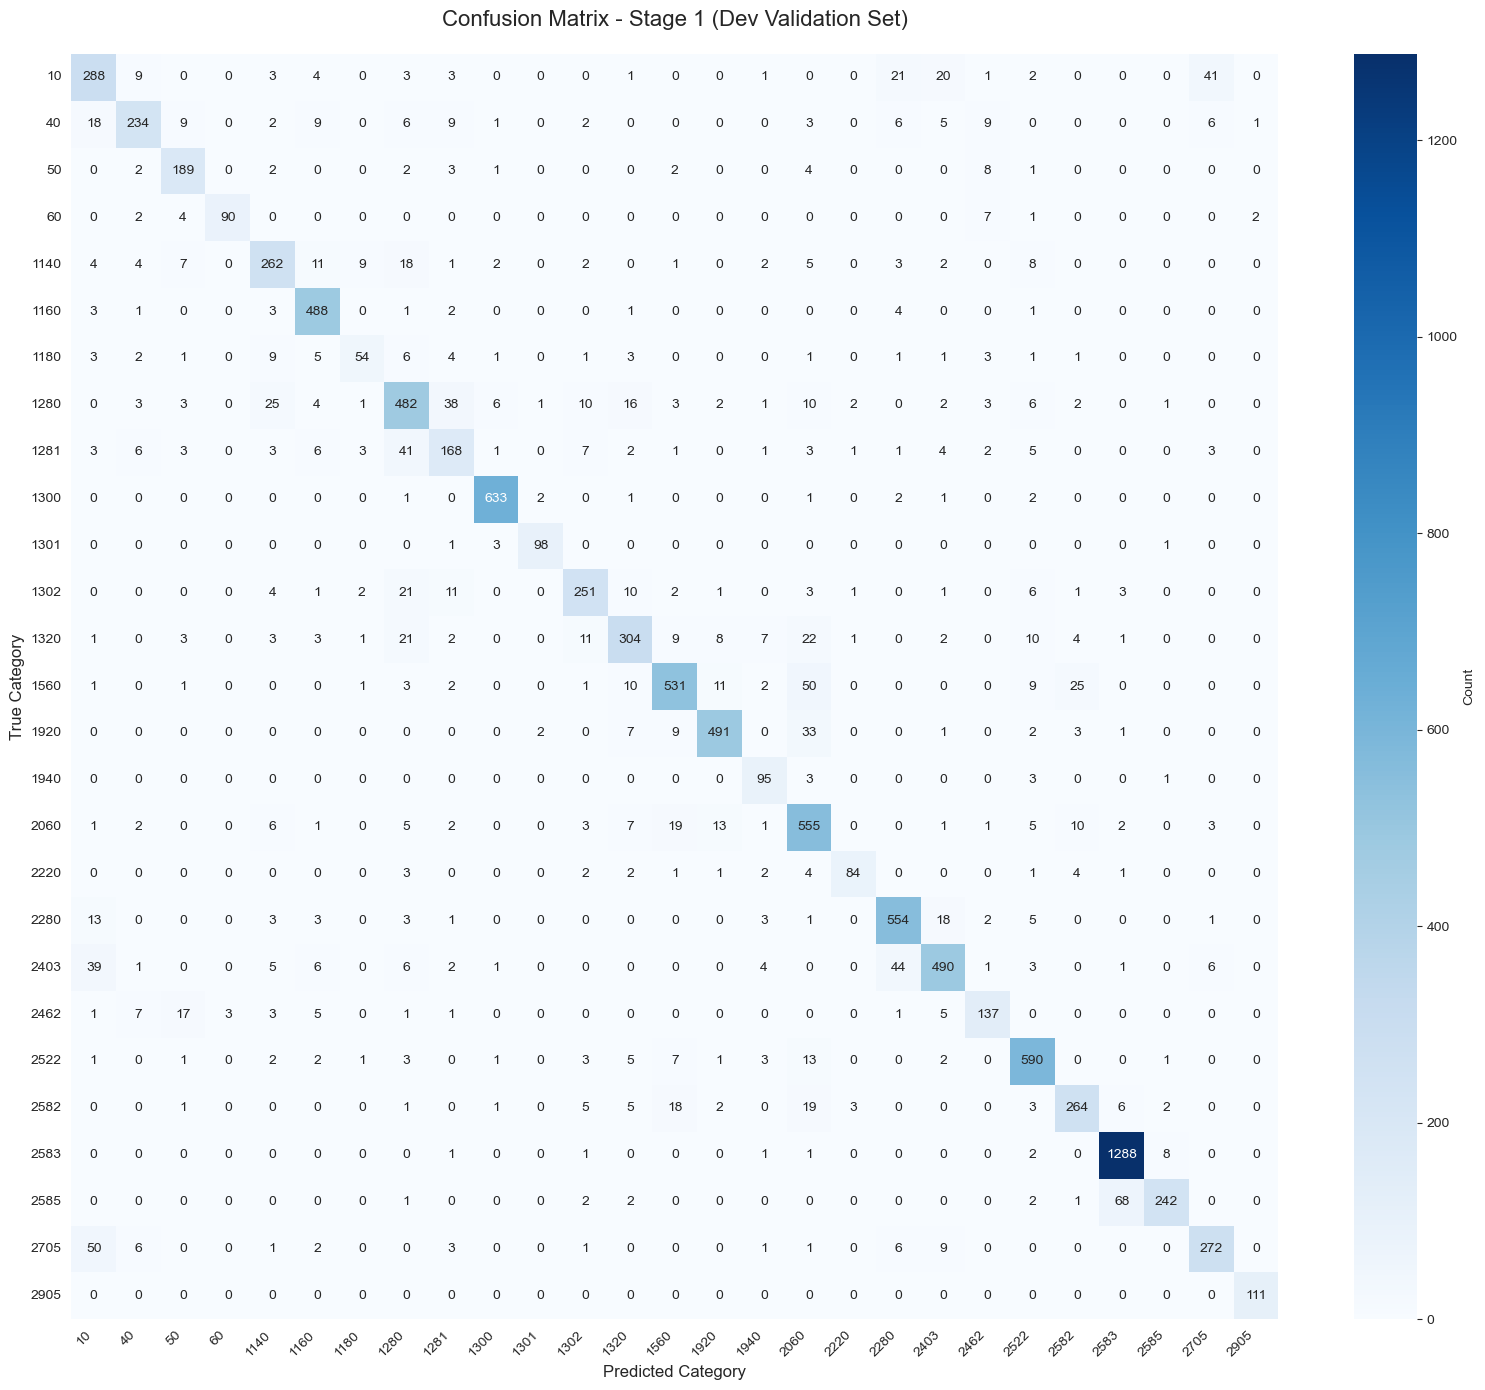

✓ Confusion matrix plotted


In [14]:
# Confusion matrix
cm_val = confusion_matrix(val_true_labels, val_predictions)

plt.figure(figsize=(16, 14))
sns.heatmap(
    cm_val, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Stage 1 (Dev Validation Set)', fontsize=16, pad=20)
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('True Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("✓ Confusion matrix plotted")

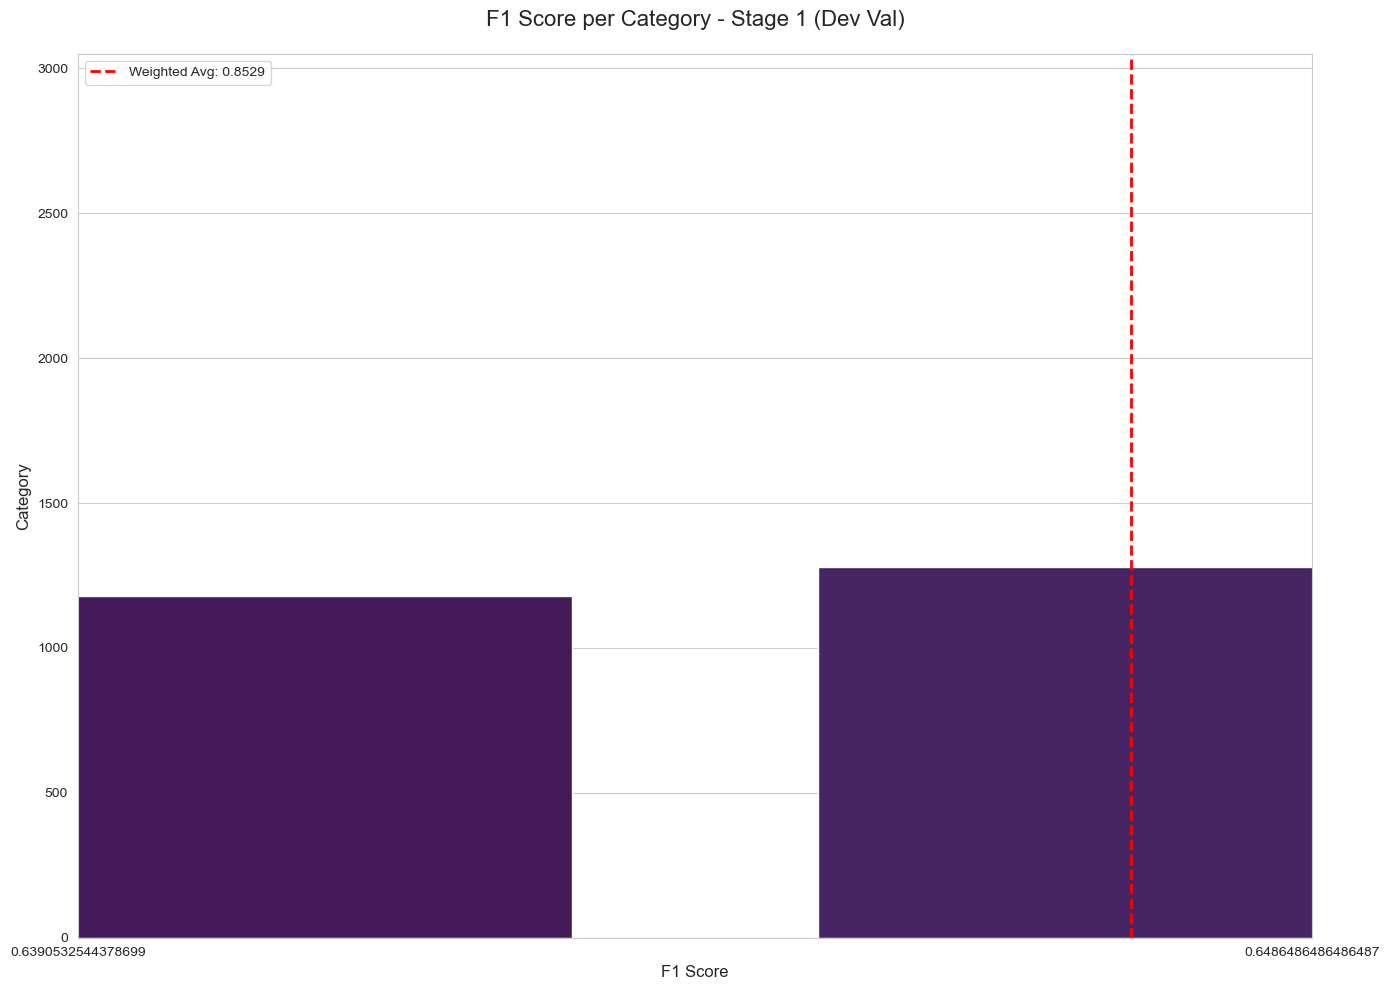

✓ Per-class performance plotted


In [15]:
# Per-class F1 scores
val_f1_per_class = f1_score(val_true_labels, val_predictions, average=None)

performance_df_val = pd.DataFrame({
    'Category': class_names,
    'F1 Score': val_f1_per_class
}).sort_values('F1 Score', ascending=False)

plt.figure(figsize=(14, 10))
sns.barplot(data=performance_df_val, x='F1 Score', y='Category', palette='viridis')
plt.title('F1 Score per Category - Stage 1 (Dev Val)', fontsize=16, pad=20)
plt.xlabel('F1 Score', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.xlim(0, 1)
plt.axvline(val_f1_weighted, color='red', linestyle='--', linewidth=2, 
            label=f'Weighted Avg: {val_f1_weighted:.4f}')
plt.legend()
plt.tight_layout()
plt.show()

print("✓ Per-class performance plotted")

---

# STAGE 2: Final Evaluation (X_holdout)

Evaluate on the holdout set that was never used during development.
This provides an unbiased estimate of model performance for fair comparison with NB01-03.

---

## 12. Stage 2: Evaluation on Holdout Set

In [16]:
print("="*80)
print("STAGE 2: FINAL HOLDOUT EVALUATION")
print("="*80)
print()

# Run evaluation on holdout set
holdout_predictions, holdout_true_labels = evaluate_model(
    model, holdout_loader, device, desc="Evaluating on Holdout Set"
)

print(f"\n✓ Holdout evaluation complete")
print(f"  Total predictions: {len(holdout_predictions):,}")

STAGE 2: FINAL HOLDOUT EVALUATION



Evaluating on Holdout Set: 100%|██████████| 797/797 [00:54<00:00, 14.50it/s]


✓ Holdout evaluation complete
  Total predictions: 12,738


## 13. Stage 2: Performance Metrics

In [17]:
# Calculate metrics
holdout_accuracy = accuracy_score(holdout_true_labels, holdout_predictions)
holdout_f1_weighted = f1_score(holdout_true_labels, holdout_predictions, average='weighted')
holdout_f1_macro = f1_score(holdout_true_labels, holdout_predictions, average='macro')

print("="*80)
print("STAGE 2 RESULTS - Final Holdout Set")
print("="*80)
print(f"\nDataset: X_holdout (never seen during development)")
print(f"Size: {len(holdout_true_labels):,} samples")
print(f"\nAccuracy:            {holdout_accuracy:.4f} ({holdout_accuracy*100:.2f}%)")
print(f"F1 Score (Weighted): {holdout_f1_weighted:.4f}")
print(f"F1 Score (Macro):    {holdout_f1_macro:.4f}")
print("="*80)

STAGE 2 RESULTS - Final Holdout Set

Dataset: X_holdout (never seen during development)
Size: 12,738 samples

Accuracy:            0.8358 (83.58%)
F1 Score (Weighted): 0.8344
F1 Score (Macro):    0.8121


In [18]:
# Classification report
print("\nDETAILED CLASSIFICATION REPORT (Stage 2)")
print("="*80)

report_holdout = classification_report(
    holdout_true_labels, 
    holdout_predictions,
    target_names=[str(c) for c in class_names],
    digits=4
)
print(report_holdout)


DETAILED CLASSIFICATION REPORT (Stage 2)
              precision    recall  f1-score   support

          10     0.6371    0.6317    0.6344       467
          40     0.8198    0.7261    0.7701       376
          50     0.7948    0.8452    0.8192       252
          60     0.9076    0.8640    0.8852       125
        1140     0.7837    0.7681    0.7758       401
        1160     0.8652    0.9629    0.9114       593
        1180     0.5281    0.4087    0.4608       115
        1280     0.7368    0.7469    0.7418       731
        1281     0.5932    0.5627    0.5776       311
        1300     0.9763    0.9789    0.9776       757
        1301     0.9667    0.9587    0.9627       121
        1302     0.7806    0.7326    0.7559       374
        1320     0.7940    0.7058    0.7473       486
        1560     0.8708    0.7884    0.8276       761
        1920     0.9098    0.8746    0.8919       646
        1940     0.7241    0.8750    0.7925       120
        2060     0.7361    0.8678    0.

## 14. Stage 2: Visualizations

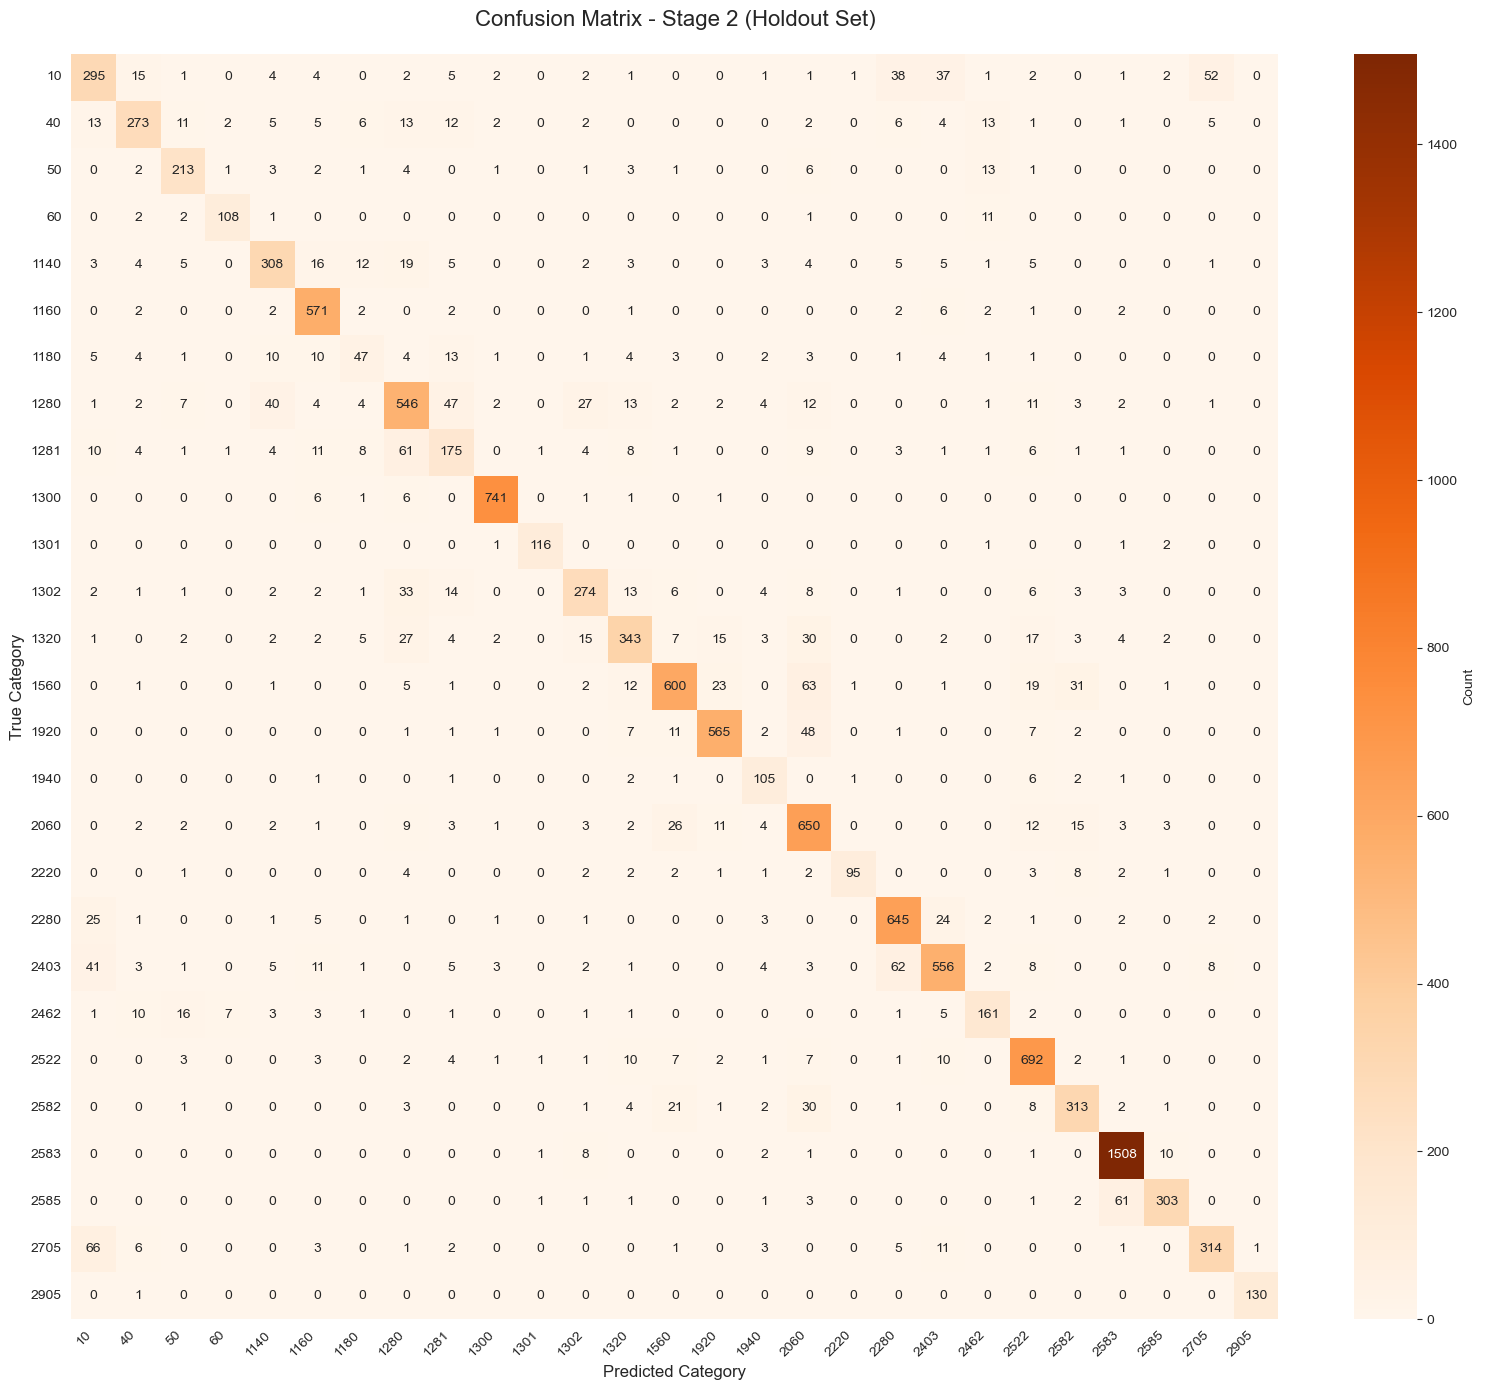

✓ Confusion matrix plotted


In [19]:
# Confusion matrix
cm_holdout = confusion_matrix(holdout_true_labels, holdout_predictions)

plt.figure(figsize=(16, 14))
sns.heatmap(
    cm_holdout, 
    annot=True, 
    fmt='d', 
    cmap='Oranges',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Stage 2 (Holdout Set)', fontsize=16, pad=20)
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('True Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("✓ Confusion matrix plotted")

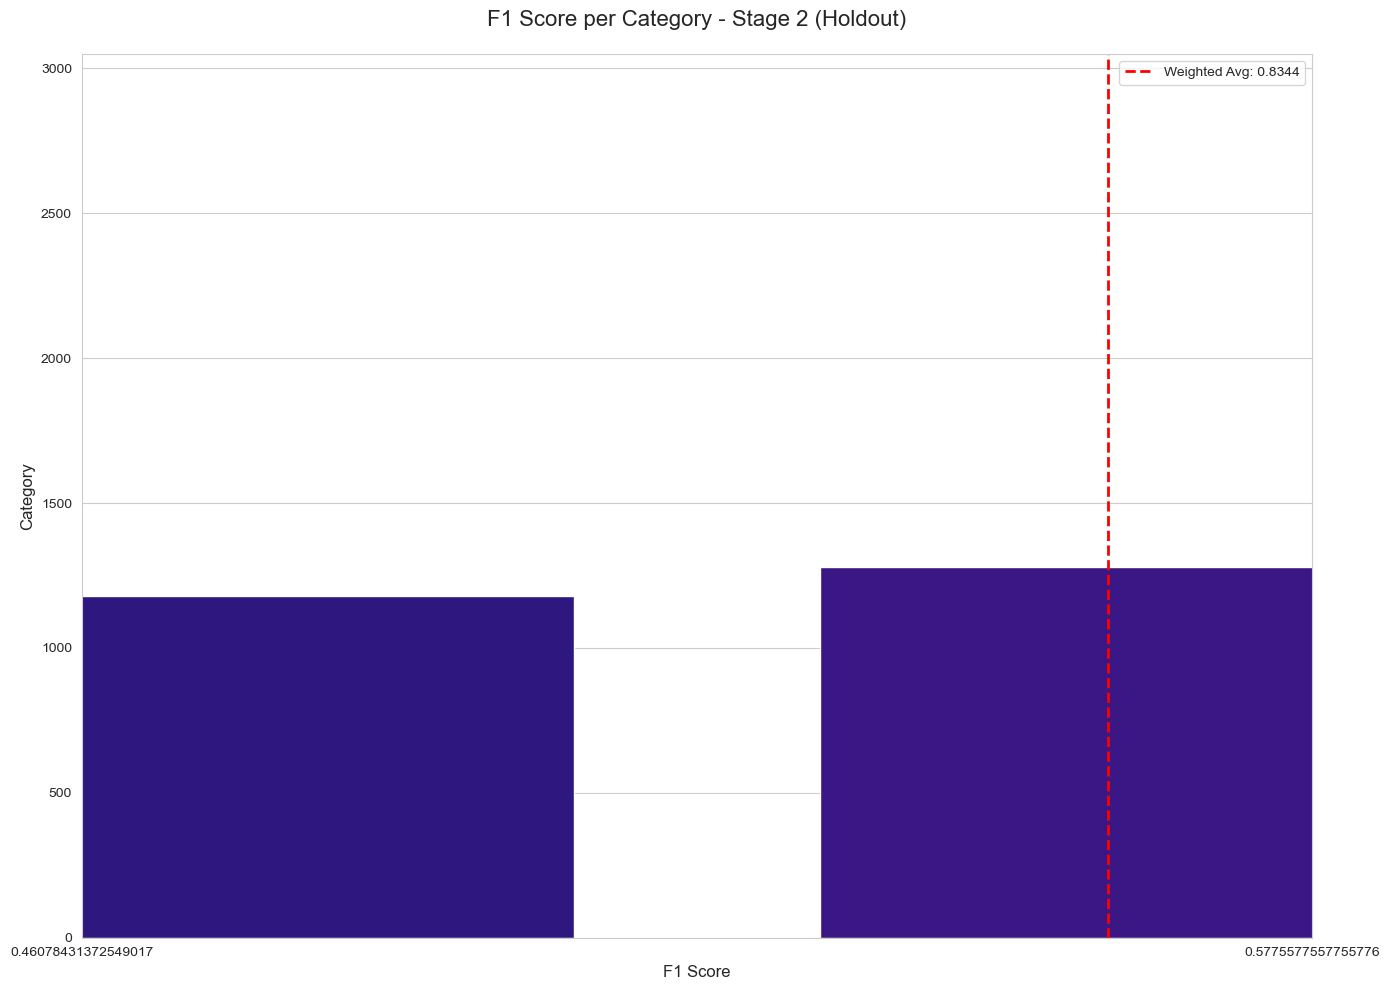

✓ Per-class performance plotted


In [20]:
# Per-class F1 scores
holdout_f1_per_class = f1_score(holdout_true_labels, holdout_predictions, average=None)

performance_df_holdout = pd.DataFrame({
    'Category': class_names,
    'F1 Score': holdout_f1_per_class
}).sort_values('F1 Score', ascending=False)

plt.figure(figsize=(14, 10))
sns.barplot(data=performance_df_holdout, x='F1 Score', y='Category', palette='plasma')
plt.title('F1 Score per Category - Stage 2 (Holdout)', fontsize=16, pad=20)
plt.xlabel('F1 Score', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.xlim(0, 1)
plt.axvline(holdout_f1_weighted, color='red', linestyle='--', linewidth=2, 
            label=f'Weighted Avg: {holdout_f1_weighted:.4f}')
plt.legend()
plt.tight_layout()
plt.show()

print("✓ Per-class performance plotted")

## 15. Comparison: Stage 1 vs Stage 2

In [21]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 (Weighted)', 'F1 (Macro)'],
    'Stage 1 (Dev Val)': [
        f"{val_accuracy:.4f}",
        f"{val_f1_weighted:.4f}",
        f"{val_f1_macro:.4f}"
    ],
    'Stage 2 (Holdout)': [
        f"{holdout_accuracy:.4f}",
        f"{holdout_f1_weighted:.4f}",
        f"{holdout_f1_macro:.4f}"
    ],
    'Difference': [
        f"{holdout_accuracy - val_accuracy:+.4f}",
        f"{holdout_f1_weighted - val_f1_weighted:+.4f}",
        f"{holdout_f1_macro - val_f1_macro:+.4f}"
    ]
})

print("="*80)
print("COMPARISON: Stage 1 (Dev Val) vs Stage 2 (Holdout)")
print("="*80)
print()
print(comparison_df.to_string(index=False))
print()
print("="*80)

COMPARISON: Stage 1 (Dev Val) vs Stage 2 (Holdout)

       Metric Stage 1 (Dev Val) Stage 2 (Holdout) Difference
     Accuracy            0.8539            0.8358    -0.0180
F1 (Weighted)            0.8529            0.8344    -0.0184
   F1 (Macro)            0.8356            0.8121    -0.0234



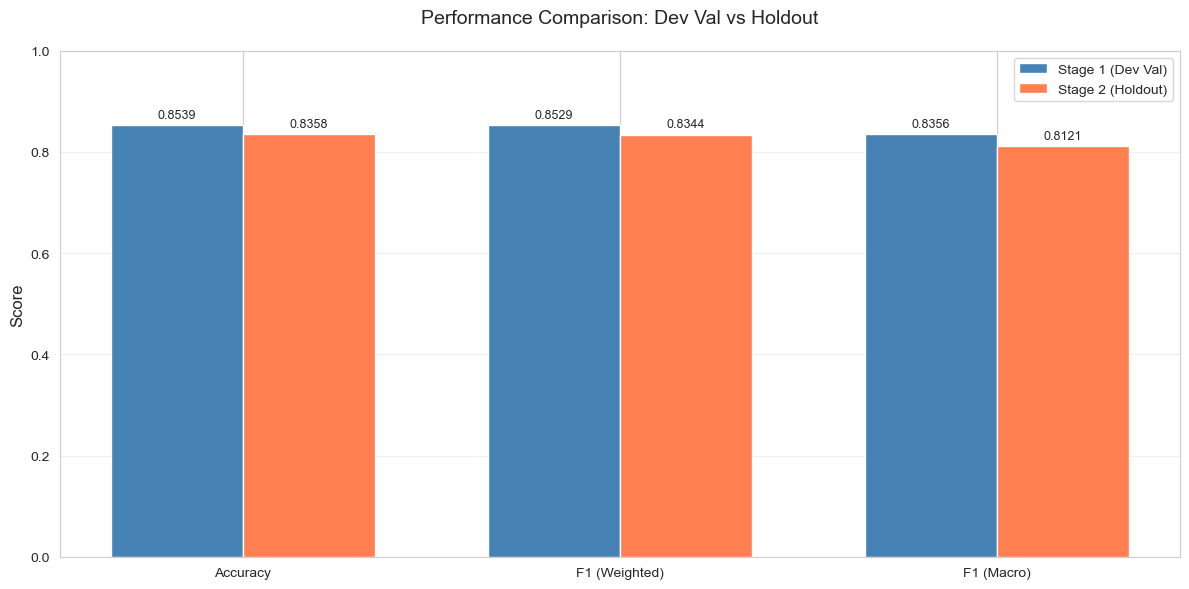

✓ Comparison visualization complete


In [22]:
# Visual comparison
metrics_data = {
    'Stage 1\n(Dev Val)': [val_accuracy, val_f1_weighted, val_f1_macro],
    'Stage 2\n(Holdout)': [holdout_accuracy, holdout_f1_weighted, holdout_f1_macro]
}

x = np.arange(3)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, metrics_data['Stage 1\n(Dev Val)'], width, 
               label='Stage 1 (Dev Val)', color='steelblue')
bars2 = ax.bar(x + width/2, metrics_data['Stage 2\n(Holdout)'], width, 
               label='Stage 2 (Holdout)', color='coral')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance Comparison: Dev Val vs Holdout', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(['Accuracy', 'F1 (Weighted)', 'F1 (Macro)'])
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

print("✓ Comparison visualization complete")

## 16. Save Results

In [23]:
import json

# Prepare results dictionary
results = {
    'model': 'DeBERTa (Gaby)',
    'model_path': MODEL_PATH,
    'preprocessing': 'gaby_preprocessing.text_preprocess',
    'config': {
        'max_length': MAX_LENGTH,
        'batch_size': BATCH_SIZE,
        'val_size': VAL_SIZE,
        'random_state': RANDOM_STATE
    },
    'stage1_dev_val': {
        'dataset': 'X_dev validation split',
        'samples': int(len(val_true_labels)),
        'accuracy': float(val_accuracy),
        'f1_weighted': float(val_f1_weighted),
        'f1_macro': float(val_f1_macro)
    },
    'stage2_holdout': {
        'dataset': 'X_holdout (unseen)',
        'samples': int(len(holdout_true_labels)),
        'accuracy': float(holdout_accuracy),
        'f1_weighted': float(holdout_f1_weighted),
        'f1_macro': float(holdout_f1_macro)
    }
}

# Save to file
output_path = 'results/deberta_evaluation.json'
os.makedirs('results', exist_ok=True)

with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print(f"✓ Results saved to: {output_path}")

✓ Results saved to: results/deberta_evaluation.json


## 17. Final Summary

In [24]:
print("="*80)
print("FINAL SUMMARY - DeBERTa Model Evaluation")
print("="*80)
print(f"\nModel: DeBERTa (from {MODEL_PATH})")
print(f"Device: {device}")
print(f"Preprocessing: gaby_preprocessing.text_preprocess")
print(f"\nConfiguration:")
print(f"  Max sequence length: {MAX_LENGTH}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Val size: {VAL_SIZE}")
print(f"  Random state: {RANDOM_STATE}")
print(f"\nData Split (Following NB01-03):")
print(f"  Total samples: {len(df_dev) + len(df_holdout):,}")
print(f"  X_dev:    {len(df_dev):,} (85%)")
print(f"  X_holdout: {len(df_holdout):,} (15%)")
print(f"\n" + "-"*80)
print(f"STAGE 1 - Development Validation Set ({len(val_true_labels):,} samples):")
print(f"  Accuracy:         {val_accuracy:.4f}")
print(f"  F1 (Weighted):    {val_f1_weighted:.4f}")
print(f"  F1 (Macro):       {val_f1_macro:.4f}")
print(f"\n" + "-"*80)
print(f"STAGE 2 - Final Holdout Set ({len(holdout_true_labels):,} samples):")
print(f"  Accuracy:         {holdout_accuracy:.4f}")
print(f"  F1 (Weighted):    {holdout_f1_weighted:.4f}")
print(f"  F1 (Macro):       {holdout_f1_macro:.4f}")
print(f"\n" + "-"*80)
print(f"Difference (Holdout - Dev Val):")
print(f"  Accuracy:         {holdout_accuracy - val_accuracy:+.4f}")
print(f"  F1 (Weighted):    {holdout_f1_weighted - val_f1_weighted:+.4f}")
print(f"  F1 (Macro):       {holdout_f1_macro - val_f1_macro:+.4f}")
print("="*80)
print("\n✓ Two-stage evaluation complete!")
print("✓ Results saved to: results/deberta_evaluation.json")
print("\n⚠️  Use Stage 2 (Holdout) results for fair comparison with NB01-03")

FINAL SUMMARY - DeBERTa Model Evaluation

Model: DeBERTa (from ../models/gaby_deberta_v1/)
Device: cuda
Preprocessing: gaby_preprocessing.text_preprocess

Configuration:
  Max sequence length: 128
  Batch size: 16
  Val size: 0.15
  Random state: 42

Data Split (Following NB01-03):
  Total samples: 84,916
  X_dev:    72,178 (85%)
  X_holdout: 12,738 (15%)

--------------------------------------------------------------------------------
STAGE 1 - Development Validation Set (10,827 samples):
  Accuracy:         0.8539
  F1 (Weighted):    0.8529
  F1 (Macro):       0.8356

--------------------------------------------------------------------------------
STAGE 2 - Final Holdout Set (12,738 samples):
  Accuracy:         0.8358
  F1 (Weighted):    0.8344
  F1 (Macro):       0.8121

--------------------------------------------------------------------------------
Difference (Holdout - Dev Val):
  Accuracy:         -0.0180
  F1 (Weighted):    -0.0184
  F1 (Macro):       -0.0234

✓ Two-stage eval